FFT VISUALIZATION & ANALYSIS


This is the Jupyter Notebook for the FFT visualization & Analysis, it consists in:

1) Comparing results with Black-Scholes and Carr-madan integral

2) Convergence analysis vs N

3) Runtime analysis vs N



### Settings (step 0):

Description: Here are installed the required standard libraries and imported custom functions, moreover here are defined the values of the strikes with which prices will be compared

In [1]:
# --- Standard Libraries -----------------------------------
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
sys.path.append("./src")


#--- Custom imports ---------------------------------------
from characteristic_functions import cf_bs
from fft_pricer import fft_pricer
from fourier_integral import call_price_carr_madan

# strike grid for price curves (step = 5)
strikes = np.linspace(60.0, 140.0, 17)

### Price Comparison (Step 1)

In [2]:
# --- Black-Scholes closed form call price -------------------------
# Black-Sholes parameters
S0 = 100.0
r = 0.01
T = 1.0
sigma = 0.2
alpha = 1.5

params = {
    "S0": S0,
    "r": r,
    "sigma": sigma,
    "T": T,
}


def bs_call_price(S0: float, K: float, r: float, T: float, sigma: float) -> float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [3]:
# Black–Scholes prices
bs_prices = np.array([bs_call_price(S0, K, r, T, sigma) for K in strikes])

# Integral prices (Carr–Madan)
cm_prices = np.array([call_price_carr_madan(K, params, alpha=alpha, u_max=200.0)[0] for K in strikes])

# FFT prices
K_fft, P_fft = fft_pricer(cf_bs, params, alpha=alpha)
fft_prices_on_grid = np.interp(strikes, K_fft, P_fft)

In [4]:
comparison_df = pd.DataFrame({
    "K": strikes,
    "BS": bs_prices,
    "Integral_CM": cm_prices,
    "FFT": fft_prices_on_grid,
})

comparison_df["err_FFT_vs_BS"] = np.abs(comparison_df["FFT"] - comparison_df["BS"])
comparison_df["err_FFT_vs_CM"] = np.abs(comparison_df["FFT"] - comparison_df["Integral_CM"])

comparison_df

,K,BS,Integral_CM,FFT,err_FFT_vs_BS,err_FFT_vs_CM
0,60.0,40.619187,40.619187,40.619207,0.000020,0.000020
1,65.0,35.723987,35.723987,35.724045,0.000058,0.000058
2,70.0,30.914112,30.914112,30.914251,0.000139,0.000139
3,75.0,26.262967,26.262967,26.263211,0.000244,0.000244
4,80.0,21.863306,21.863306,21.863534,0.000228,0.000228
5,85.0,17.812204,17.812204,17.812295,0.000091,0.000091
6,90.0,14.192920,14.192920,14.193605,0.000685,0.000685
7,95.0,11.060210,11.060210,11.060691,0.000481,0.000481
8,100.0,8.433319,8.433319,8.434244,0.000926,0.000926
9,105.0,6.297255,6.297255,6.298187,0.000933,0.000933


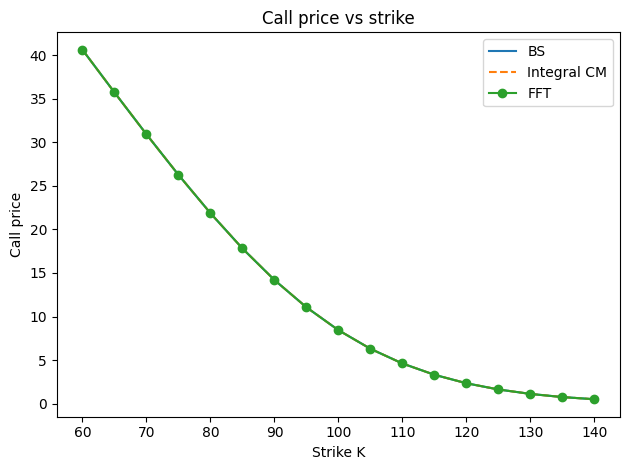

In [5]:
# --- Price vs Strike plot --------------------------------
plt.figure()
plt.plot(strikes, bs_prices, label="BS")
plt.plot(strikes, cm_prices, "--", label="Integral CM")
plt.plot(strikes, fft_prices_on_grid, "o-", label="FFT")
plt.xlabel("Strike K")
plt.ylabel("Call price")
plt.title("Call price vs strike")
plt.legend()
plt.tight_layout()
plt.show()

### Convergence Rate and Runtime comparison (Step 2)

To study the convergence rate of the FFT pricer, we fix a reference strike and compare the FFT price with the Black–Scholes benchmark while varying N, which controls the resolution of the discrete Fourier grid


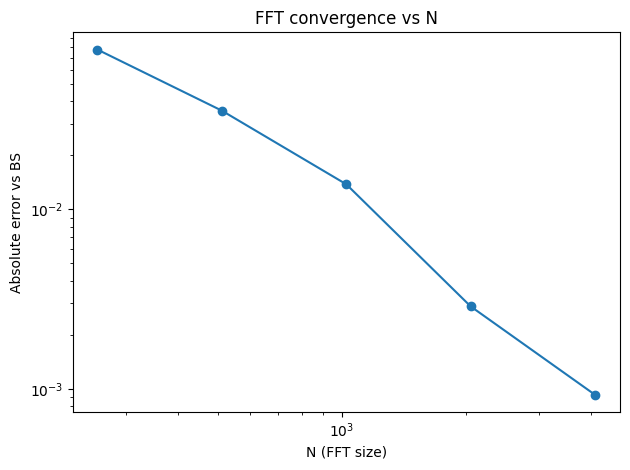

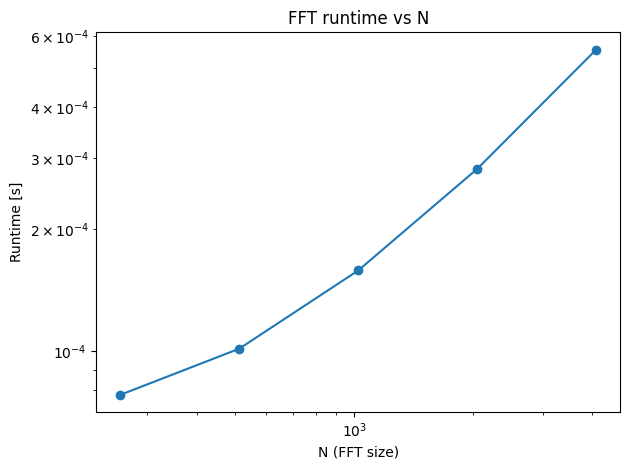

In [6]:
# --- FFT Convergence analysis and runtime ---------------------------
K0 = 100.0
bs_ref = bs_call_price(S0, K0, r, T, sigma)

N_values = [2**8, 2**9, 2**10, 2**11, 2**12]
errors_fft = []
times_fft = []

num_runs = 1000

for N in N_values:
    t0 = time.time()
    for _ in range(num_runs):
        K_fft, P_fft = fft_pricer(cf_bs, params, alpha=alpha, N=N)
    t1 = time.time()
    price_fft = np.interp(K0, K_fft, P_fft)
    errors_fft.append(abs(price_fft - bs_ref))
    avg_time = (t1 - t0) / num_runs
    times_fft.append(avg_time)

fft_conv_df = pd.DataFrame({
    "N": N_values,
    "error_fft": errors_fft,
    "time_fft": times_fft,
})

fft_runtime_df = pd.DataFrame({
    "N": N_values,
    "time_fft": times_fft,
})

# --- Plot FFT convergence -------------------------------
plt.figure()
plt.loglog(N_values, errors_fft, "o-")
plt.xlabel("N (FFT size)")
plt.ylabel("Absolute error vs BS")
plt.title("FFT convergence vs N")
plt.tight_layout()
plt.show()

# --- Plot FFT runtime -----------------------------------
plt.figure()
plt.loglog(N_values, times_fft, "o-")
plt.xlabel("N (FFT size)")
plt.ylabel("Runtime [s]")
plt.title("FFT runtime vs N")
plt.tight_layout()
plt.show()